## Initial Import

In [1]:
#%pip install imblearn
#%pip install xgboost

In [58]:
import pandas as pd
import numpy  as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.combine import SMOTETomek

from xgboost import XGBClassifier

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner)

## Data Cleaning

In [3]:
app = pd.read_csv('Base.csv')

In [4]:
app['fraud_bool'].value_counts(normalize=True)*100

0    98.8971
1     1.1029
Name: fraud_bool, dtype: float64

**It is observed that we have an extremely imbalanced dataset. Fraud transactions accounts for 1.1% of total rows.**

### Missing Values

1M record of bank account applications. No missing values in raw dataset.

In [5]:
app.isnull().sum()

fraud_bool                          0
income                              0
name_email_similarity               0
prev_address_months_count           0
current_address_months_count        0
customer_age                        0
days_since_request                  0
intended_balcon_amount              0
payment_type                        0
zip_count_4w                        0
velocity_6h                         0
velocity_24h                        0
velocity_4w                         0
bank_branch_count_8w                0
date_of_birth_distinct_emails_4w    0
employment_status                   0
credit_risk_score                   0
email_is_free                       0
housing_status                      0
phone_home_valid                    0
phone_mobile_valid                  0
bank_months_count                   0
has_other_cards                     0
proposed_credit_limit               0
foreign_request                     0
source                              0
session_leng

### Encode Categorical Columns

**Payment Type**

In [6]:
app['payment_type'].value_counts()

AB    370554
AA    258249
AC    252071
AD    118837
AE       289
Name: payment_type, dtype: int64

In [7]:
app = app.join(pd.get_dummies(app['payment_type']))

In [8]:
app.rename(columns={'payment_type':'pay_type', 'AA':'pt_AA', 'AB':'pt_AB', 'AC':'pt_AC', 
                    'AD':'pt_AD', 'AE':'pt_AE'}, inplace=True)

**Employment Status**

In [9]:
app['employment_status'].value_counts()

CA    730252
CB    138288
CF     44034
CC     37758
CD     26522
CE     22693
CG       453
Name: employment_status, dtype: int64

In [10]:
app = app.join(pd.get_dummies(app['employment_status']))

In [11]:
app.rename(columns={'employment_status':'emp_stat', 'CA':'es_CA', 'CB':'es_CB', 'CC':'es_CC',
                    'CD':'es_CD', 'CE':'es_CE', 'CF':'es_CF', 'CG':'es_CG'}, 
           inplace=True)

**Housing Status**

In [12]:
app['housing_status'].value_counts()

BC    372143
BB    260965
BA    169675
BE    169135
BD     26161
BF      1669
BG       252
Name: housing_status, dtype: int64

Fraud rate for BE, BF, BG are very similar, given small class size for BF, BG, BF and BG will be merged to class BE. 

In [13]:
def merge_class(i):
    if i == 'BF' or i == 'BG':
        return 'BE'
    else:
        return i

In [14]:
app['housing_status'] = app['housing_status'].apply(lambda x: merge_class(x))

In [15]:
app['housing_status'].unique()

array(['BA', 'BB', 'BC', 'BD', 'BE'], dtype=object)

In [16]:
app = app.join(pd.get_dummies(app['housing_status']))

In [17]:
app.rename(columns={'housing_status':'hous_stat', 'BA':'hs_BA', 'BB':'hs_BB', 'BC':'hs_BC', 
                    'BD':'hs_BD', 'BE':'hs_BE'}, 
           inplace=True)

**Source**

In [18]:
app['source'].value_counts()

INTERNET    992952
TELEAPP       7048
Name: source, dtype: int64

**Notice that majority of applications come from 'INTERNET' source, therefore, dropping this column as it won't contribute much.**

In [19]:
app.drop(columns=['source'], inplace=True)

**Device OS**

In [20]:
app['device_os'].value_counts()

other        342728
linux        332712
windows      263506
macintosh     53826
x11            7228
Name: device_os, dtype: int64

In [21]:
app = app.join(pd.get_dummies(app['device_os']))

In [22]:
app.rename(columns={'other':'os_oth', 'linux':'os_lin', 'windows':'os_win', 'macintosh':'os_mac', 
                    'x11':'os_x11'}, 
           inplace=True)

### Continuous Variables

**Removing 'device_fraud_count' column since it only contains 1 value.**

In [23]:
app['device_fraud_count'].unique()

array([0])

In [24]:
app.drop(columns=['device_fraud_count'], inplace=True)

**Majority of applications are not originated from overseas. Remove this column.**

In [25]:
app['foreign_request'].value_counts()

0    974758
1     25242
Name: foreign_request, dtype: int64

In [26]:
app.drop(columns=['foreign_request'], inplace=True)

**Replace unreasonable values: average number of applications made in last 6 hours should not be negative. However, following the other column's formatting, negative application numbers will all be set to -1 which denotes no applications.**

In [27]:
app['velocity_6h'] = app['velocity_6h'].apply(lambda x: -1 if x<0 else x)

-1 signifies that intended initial deposit amount is missing, since majority of applications are missing this information, therefore, we will convert this column to categorial column (0 = missing initial deposit value, 1 = initial deposit value provided)

In [28]:
app['intended_balcon_amount'] = app['intended_balcon_amount'].apply(lambda x: 0 if x<=0 else 1)

## Exploratory Data Analysis

In [30]:
def value_mapping(i):
    data_dict = app[i].unique()
    val_dict  = {}
    for i, j in enumerate(data_dict):
        val_dict[j] = i
    return val_dict

In [31]:
pay_type  = value_mapping('pay_type')
emp_stat  = value_mapping('emp_stat')
hous_stat = value_mapping('hous_stat')
device_os = value_mapping('device_os')

In [32]:
app['pay_type_m']  = app['pay_type'].apply(lambda x: pay_type[x])
app['emp_stat_m']  = app['emp_stat'].apply(lambda x: emp_stat[x])
app['hous_stat_m'] = app['hous_stat'].apply(lambda x: hous_stat[x])
app['device_os_m'] = app['device_os'].apply(lambda x: device_os[x])

In [33]:
dummies = ['pt_AA', 'pt_AB', 'pt_AC', 'pt_AD', 'pt_AE', 
           'es_CA', 'es_CB', 'es_CC', 'es_CD', 'es_CE', 'es_CF', 'es_CG', 
           'hs_BA', 'hs_BB', 'hs_BC', 'hs_BD', 'hs_BE', 
           'os_lin', 'os_mac', 'os_oth', 'os_win', 'os_x11']

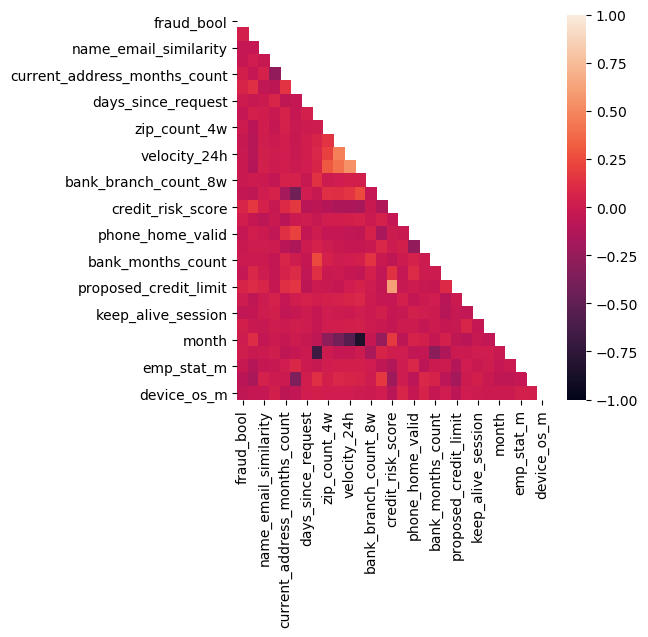

In [33]:
plt.figure(figsize=(5,5))
matrix = app.drop(columns=dummies+['pay_type', 'emp_stat', 'hous_stat', 'device_os']).corr()
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, vmin=-1, vmax=1, mask=mask);
plt.show()

### Categorical Variable

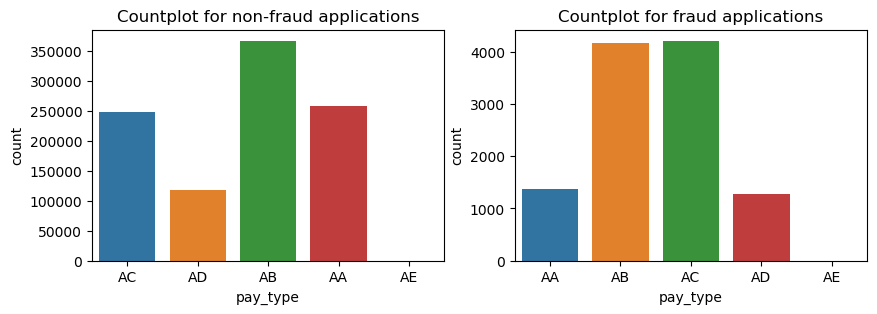

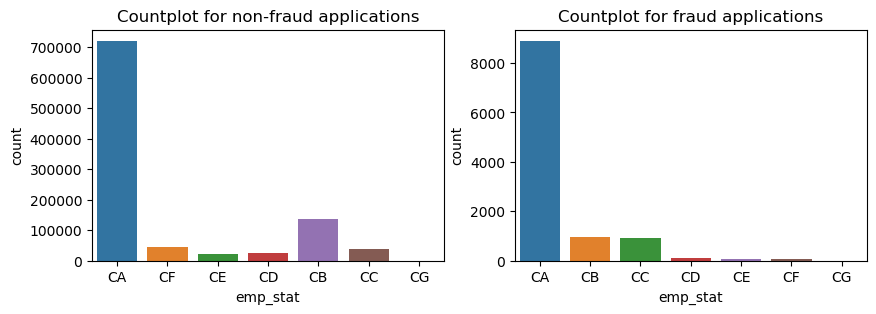

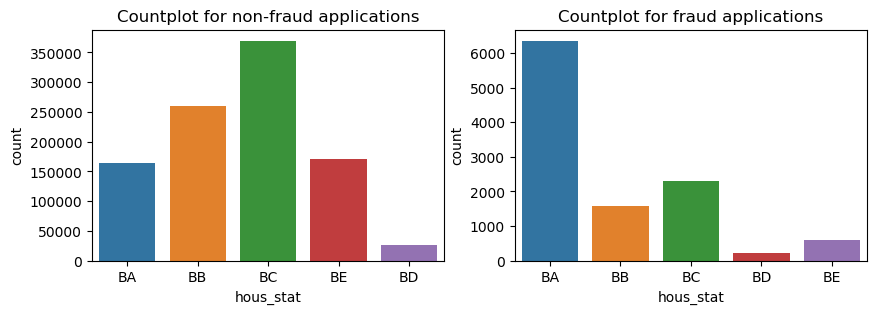

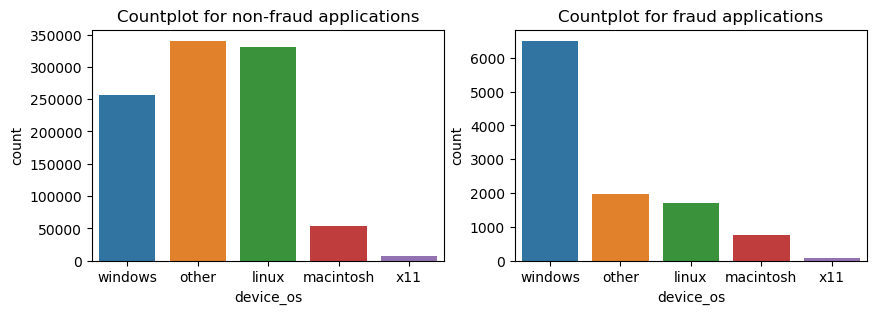

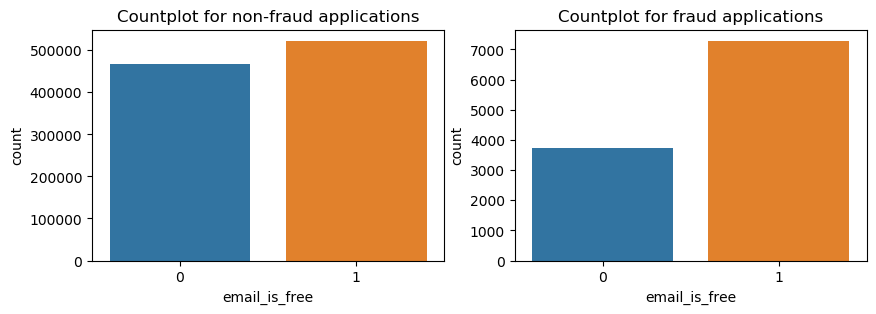

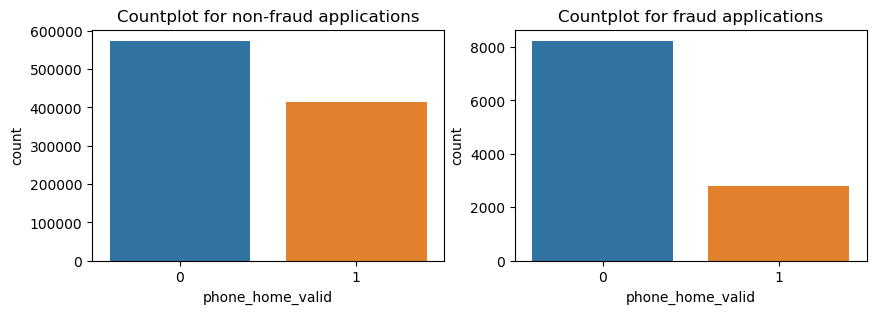

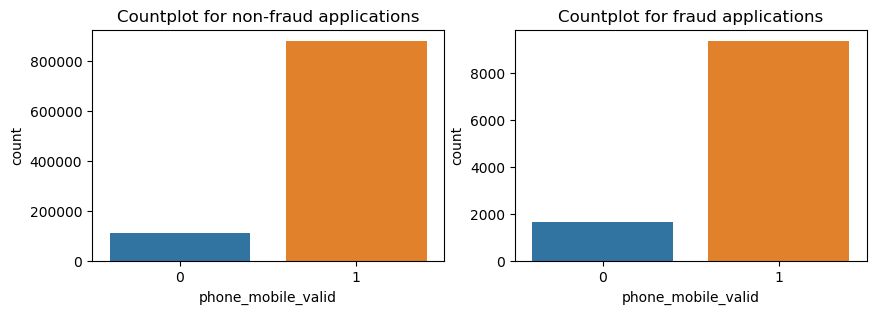

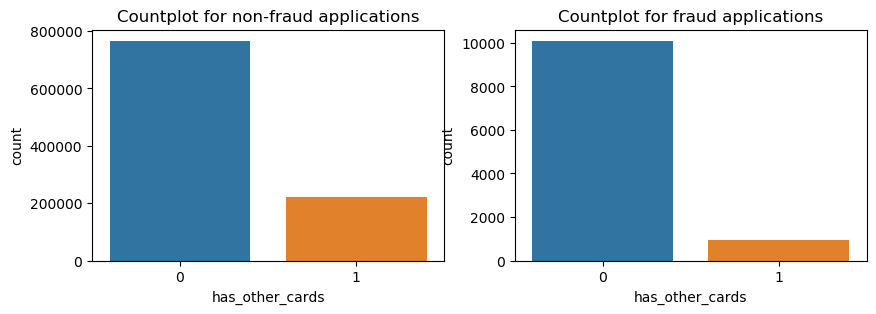

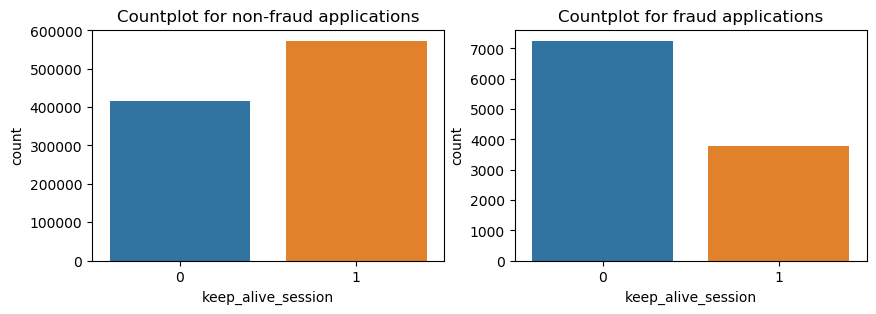

In [34]:
for i in ['pay_type', 'emp_stat', 'hous_stat', 'device_os', 'email_is_free',
          'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'keep_alive_session']:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3));
    sns.countplot(data=app[app['fraud_bool']==0], x=i, ax=ax[0]);
    sns.countplot(data=app[app['fraud_bool']==1], x=i, ax=ax[1]);
    ax[0].set_title('Countplot for non-fraud applications');
    ax[1].set_title('Countplot for fraud applications');
    plt.show();

since majority of applicants' employment status is CA, we will drop this column. 

In [34]:
app.drop(columns=['emp_stat', 'emp_stat_m', 'es_CA', 'es_CB', 'es_CC', 'es_CD', 
                  'es_CE', 'es_CF', 'es_CG'], inplace=True)

In [35]:
es = ['es_CA','es_CB','es_CC','es_CD','es_CE','es_CF','es_CG']
dummies = [i for i in dummies if i not in es]

Percentage of valid phone number for positive and negative class are quite similar. We will drop this column. 

In [36]:
app.drop(columns=['phone_mobile_valid'], inplace=True)

### Continuous Variables

In [37]:
to_remove = ['pay_type', 'hous_stat', 'device_os', 
             'pay_type_m', 'hous_stat_m', 'device_os_m']

In [38]:
cont_var = app.drop(columns=to_remove+['fraud_bool']+dummies).columns

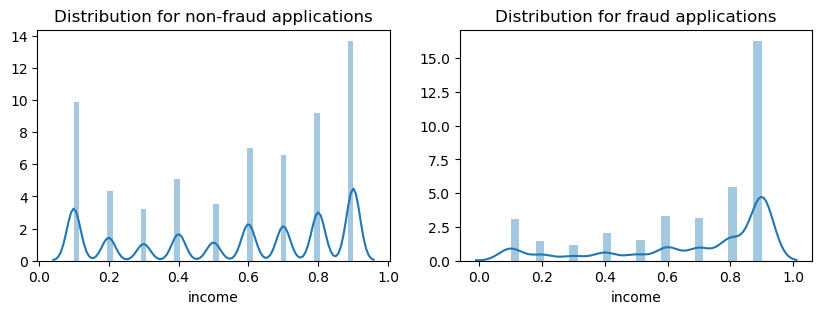

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3));
sns.distplot(app[app['fraud_bool']==0]['income'], ax=ax[0]);
sns.distplot(app[app['fraud_bool']==1]['income'], ax=ax[1]);
ax[0].set_title('Distribution for non-fraud applications');
ax[1].set_title('Distribution for fraud applications');
plt.show();

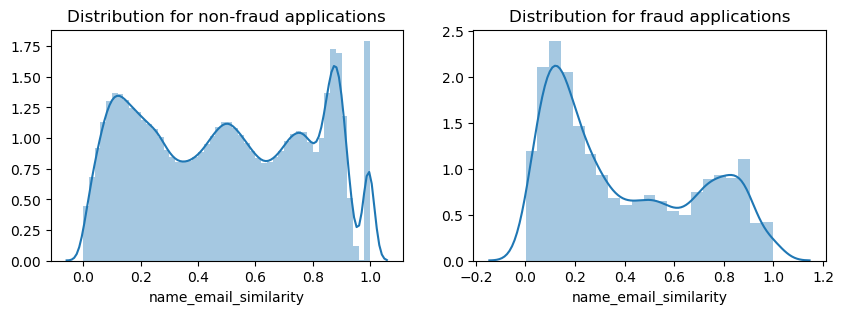

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3));
sns.distplot(app[app['fraud_bool']==0]['name_email_similarity'], ax=ax[0]);
sns.distplot(app[app['fraud_bool']==1]['name_email_similarity'], ax=ax[1]);
ax[0].set_title('Distribution for non-fraud applications');
ax[1].set_title('Distribution for fraud applications');
plt.show();

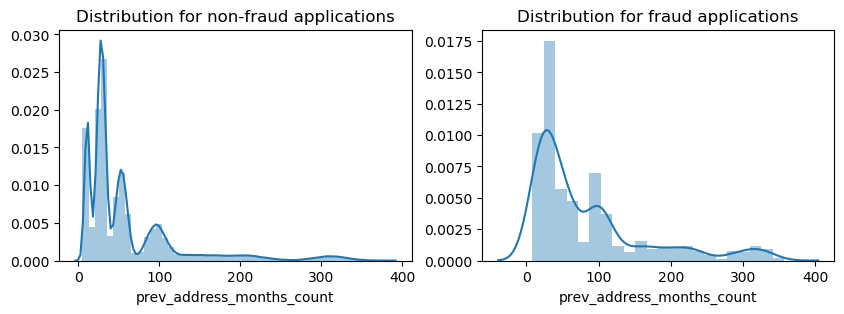

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3));
sns.distplot(app[(app['fraud_bool']==0)&(app['prev_address_months_count']>0)]['prev_address_months_count'], ax=ax[0]);
sns.distplot(app[(app['fraud_bool']==1)&(app['prev_address_months_count']>0)]['prev_address_months_count'], ax=ax[1]);
ax[0].set_title('Distribution for non-fraud applications');
ax[1].set_title('Distribution for fraud applications');
plt.show();

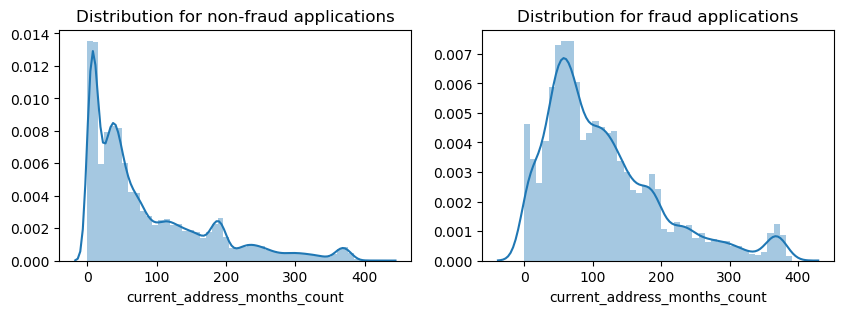

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3));
sns.distplot(app[app['fraud_bool']==0]['current_address_months_count'], ax=ax[0]);
sns.distplot(app[app['fraud_bool']==1]['current_address_months_count'], ax=ax[1]);
ax[0].set_title('Distribution for non-fraud applications');
ax[1].set_title('Distribution for fraud applications');
plt.show();

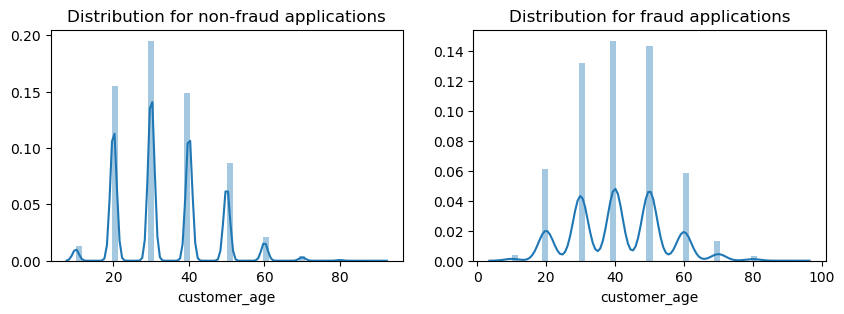

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3));
sns.distplot(app[app['fraud_bool']==0]['customer_age'], ax=ax[0]);
sns.distplot(app[app['fraud_bool']==1]['customer_age'], ax=ax[1]);
ax[0].set_title('Distribution for non-fraud applications');
ax[1].set_title('Distribution for fraud applications');
plt.show();

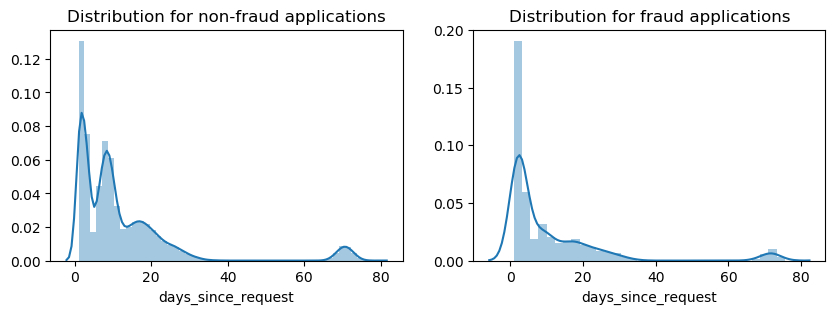

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3));
sns.distplot(app[(app['fraud_bool']==0)&(app['days_since_request']>1)]['days_since_request'], ax=ax[0]);
sns.distplot(app[(app['fraud_bool']==1)&(app['days_since_request']>1)]['days_since_request'], ax=ax[1]);
ax[0].set_title('Distribution for non-fraud applications');
ax[1].set_title('Distribution for fraud applications');
plt.show();

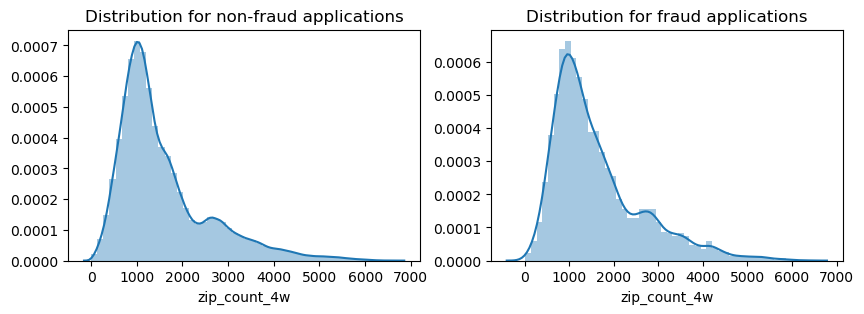

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3));
sns.distplot(app[app['fraud_bool']==0]['zip_count_4w'], ax=ax[0]);
sns.distplot(app[app['fraud_bool']==1]['zip_count_4w'], ax=ax[1]);
ax[0].set_title('Distribution for non-fraud applications');
ax[1].set_title('Distribution for fraud applications');
plt.show();

distribution of number of application from the same zip code is very similar for both fraud and non-fraud applications. Therefore, we will drop this column. 

In [39]:
app.drop(columns=['zip_count_4w'], inplace=True)

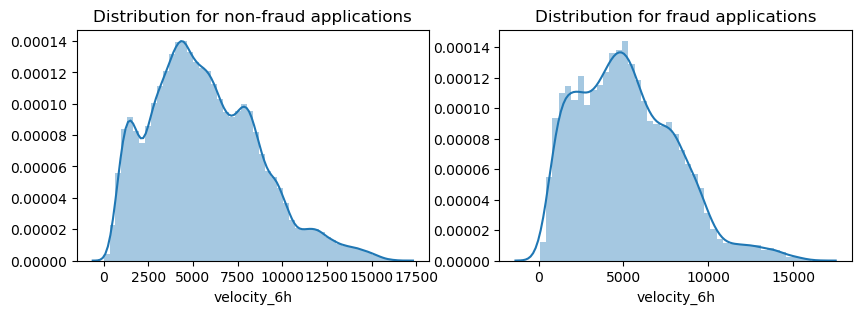

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3));
sns.distplot(app[app['fraud_bool']==0]['velocity_6h'], ax=ax[0]);
sns.distplot(app[app['fraud_bool']==1]['velocity_6h'], ax=ax[1]);
ax[0].set_title('Distribution for non-fraud applications');
ax[1].set_title('Distribution for fraud applications');
plt.show();

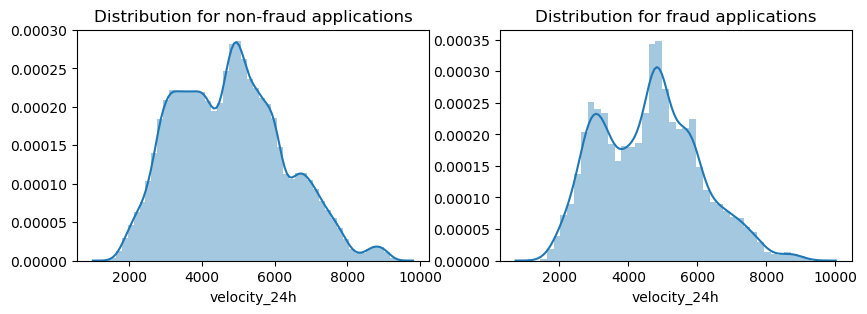

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3));
sns.distplot(app[app['fraud_bool']==0]['velocity_24h'], ax=ax[0]);
sns.distplot(app[app['fraud_bool']==1]['velocity_24h'], ax=ax[1]);
ax[0].set_title('Distribution for non-fraud applications');
ax[1].set_title('Distribution for fraud applications');
plt.show();

Distribution of velocity_24h for both fraud and non-fraud applications are quite similar. Therefore, drop this column. 

In [40]:
app.drop(columns=['velocity_24h'], inplace=True)

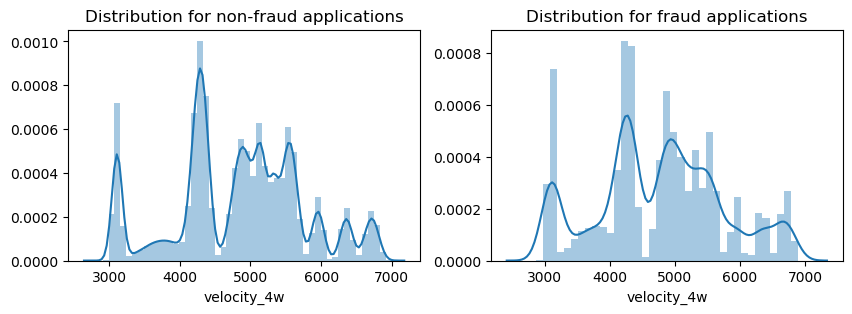

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3));
sns.distplot(app[app['fraud_bool']==0]['velocity_4w'], ax=ax[0]);
sns.distplot(app[app['fraud_bool']==1]['velocity_4w'], ax=ax[1]);
ax[0].set_title('Distribution for non-fraud applications');
ax[1].set_title('Distribution for fraud applications');
plt.show();

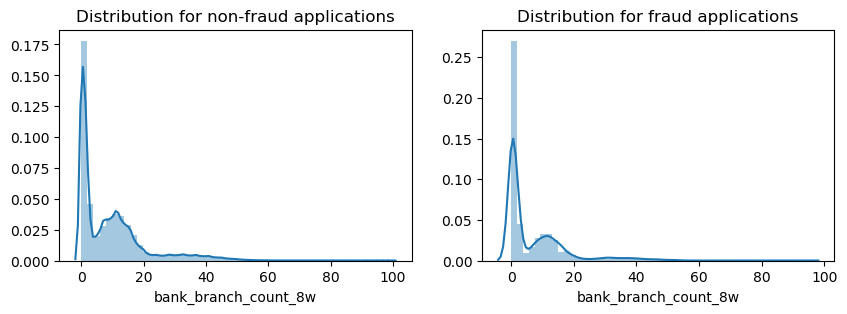

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3));
sns.distplot(app[(app['fraud_bool']==0)&(app['bank_branch_count_8w']<100)]['bank_branch_count_8w'], ax=ax[0]);
sns.distplot(app[(app['fraud_bool']==1)&(app['bank_branch_count_8w']<100)]['bank_branch_count_8w'], ax=ax[1]);
ax[0].set_title('Distribution for non-fraud applications');
ax[1].set_title('Distribution for fraud applications');
plt.show();

Distribution of bank_branch_count_8w are very similar for positive class and negative class. Therefore, drop this column.

In [41]:
app.drop(columns=['bank_branch_count_8w'], inplace=True)

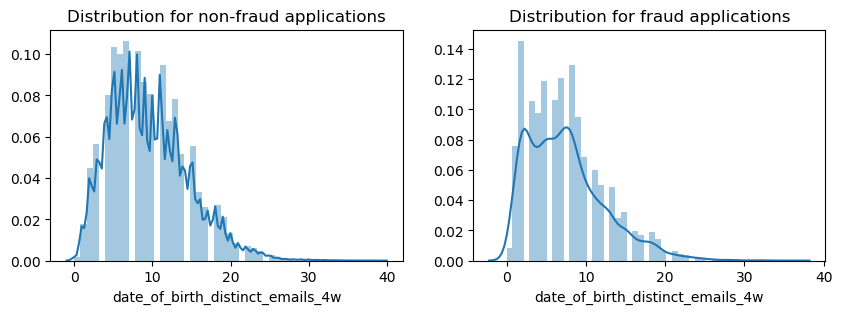

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3));
sns.distplot(app[app['fraud_bool']==0]['date_of_birth_distinct_emails_4w'], ax=ax[0]);
sns.distplot(app[app['fraud_bool']==1]['date_of_birth_distinct_emails_4w'], ax=ax[1]);
ax[0].set_title('Distribution for non-fraud applications');
ax[1].set_title('Distribution for fraud applications');
plt.show();

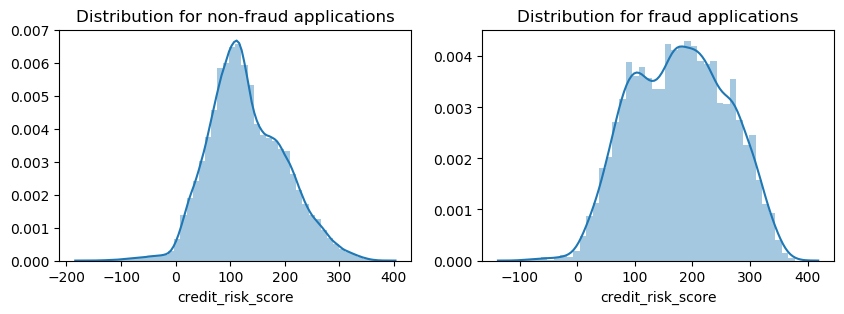

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3));
sns.distplot(app[app['fraud_bool']==0]['credit_risk_score'], ax=ax[0]);
sns.distplot(app[app['fraud_bool']==1]['credit_risk_score'], ax=ax[1]);
ax[0].set_title('Distribution for non-fraud applications');
ax[1].set_title('Distribution for fraud applications');
plt.show();

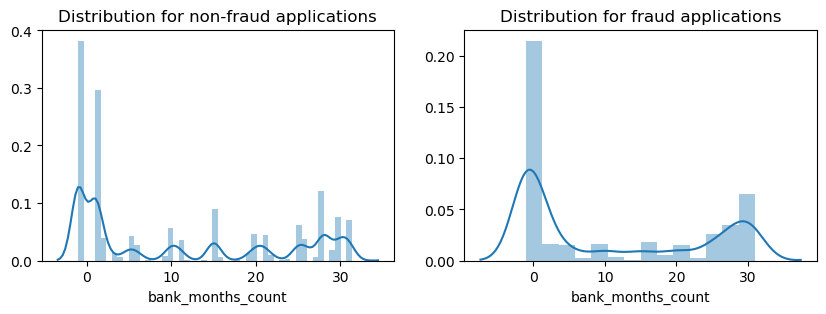

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3));
sns.distplot(app[app['fraud_bool']==0]['bank_months_count'], ax=ax[0]);
sns.distplot(app[app['fraud_bool']==1]['bank_months_count'], ax=ax[1]);
ax[0].set_title('Distribution for non-fraud applications');
ax[1].set_title('Distribution for fraud applications');
plt.show();

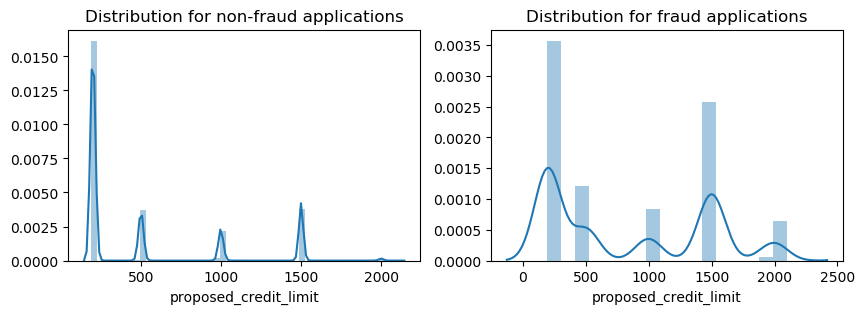

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3));
sns.distplot(app[app['fraud_bool']==0]['proposed_credit_limit'], ax=ax[0]);
sns.distplot(app[app['fraud_bool']==1]['proposed_credit_limit'], ax=ax[1]);
ax[0].set_title('Distribution for non-fraud applications');
ax[1].set_title('Distribution for fraud applications');
plt.show();

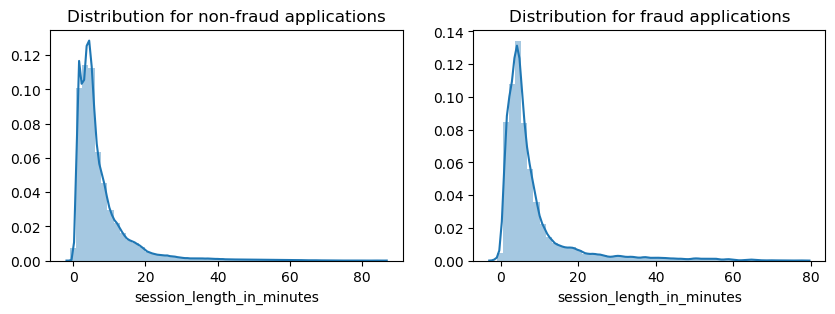

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3));
sns.distplot(app[app['fraud_bool']==0]['session_length_in_minutes'], ax=ax[0]);
sns.distplot(app[app['fraud_bool']==1]['session_length_in_minutes'], ax=ax[1]);
ax[0].set_title('Distribution for non-fraud applications');
ax[1].set_title('Distribution for fraud applications');
plt.show();

Session length doesn't differ much between positive and negative class. Therefore, drop this column. 

In [42]:
app.drop(columns=['session_length_in_minutes'], inplace=True)

In [43]:
app['device_distinct_emails_8w'].value_counts()

 1    968067
 2     25302
 0      6272
-1       359
Name: device_distinct_emails_8w, dtype: int64

Majority of applications are done using distinct email address. Therefore, drop this column. 

In [44]:
app.drop(columns=['device_distinct_emails_8w'], inplace=True)

In [45]:
features = ['income', 'name_email_similarity', 'prev_address_months_count', 
            'current_address_months_count', 'customer_age', 'days_since_request', 
            'intended_balcon_amount', 'velocity_6h', 'velocity_4w',
            'date_of_birth_distinct_emails_4w', 'credit_risk_score',
            'email_is_free', 'phone_home_valid', 'bank_months_count', 'has_other_cards', 
            'proposed_credit_limit', 'keep_alive_session', 'month', 
            'pt_AA', 'pt_AB', 'pt_AC', 'pt_AD', 'pt_AE', 
            'hs_BA', 'hs_BB', 'hs_BC', 'hs_BD', 'hs_BE', 
            'os_lin', 'os_mac', 'os_oth', 'os_win', 'os_x11']

In [46]:
target = ['fraud_bool']

## Models

**Common Functions**

In [47]:
# define function to get the prediction & prediction probability and run metrics function
def model_metrics(model, X_test, y_test):
    model_pred = model.predict(X_test)
    model_proba = [i[1] for i in model.predict_proba(X_test)]

    print('Model Statistics')
    print('-------------------------------------------------------')
    print(f'ROC-AUC   : {roc_auc_score(y_test, model_proba):.4f}')
    print(f'Recall    : {recall_score(y_test, model_pred):.4f}')
    print(f'Precision : {precision_score(y_test, model_pred):.4f}')
    print(f'F1 Score  : {f1_score(y_test, model_pred):.4f}')
    print(f'Accuracy  : {accuracy_score(y_test, model_pred):.4f}')
    print('--------------------------------------------------------')
    print(pd.DataFrame(confusion_matrix(y_test, model_pred), 
                        index=['Actual Non-fraud', 'Actual fraud'], 
                        columns=['Predicted Non-fraud', 'Predicted fraud']))
    print('-------------------------------------------------------')

### Model with No Tuning

Resampling

In [48]:
x = app[app['month']<=6][features]
y = app[app['month']<=6][target]

In [49]:
st = SMOTE(random_state = 42, sampling_strategy=1)
x_st, y_st = st.fit_resample(x, y)

In [68]:
x_train,x_test,y_train,y_test = train_test_split(x_st,y_st,test_size=0.2,random_state=42)

Logistic Regression - SMOTETomek

In [77]:
lr_smote = LogisticRegression(max_iter=1000)
lr_smote.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

In [85]:
model_metrics(lr_smote, x_test, y_test)

Model Statistics
-------------------------------------------------------
ROC-AUC   : 0.9180
Recall    : 0.8455
Precision : 0.8477
F1 Score  : 0.8466
Accuracy  : 0.8463
--------------------------------------------------------
                  Predicted Non-fraud  Predicted fraud
Actual Non-fraud               132917            23978
Actual fraud                    24392           133449
-------------------------------------------------------


Random Forest - SMOTETomek

In [82]:
rf_smote = RandomForestClassifier(random_state = 42)
rf_smote.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [86]:
model_metrics(rf_smote, x_test, y_test)

Model Statistics
-------------------------------------------------------
ROC-AUC   : 0.9990
Recall    : 0.9907
Precision : 0.9981
F1 Score  : 0.9944
Accuracy  : 0.9944
--------------------------------------------------------
                  Predicted Non-fraud  Predicted fraud
Actual Non-fraud               156597              298
Actual fraud                     1466           156375
-------------------------------------------------------


XGBoost - SMOTETomek

In [80]:
xgb_smote = XGBClassifier(random_state = 42, eval_metric = 'auc', use_label_encoder=False)
xgb_smote.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [87]:
model_metrics(xgb_smote, x_test, y_test)

Model Statistics
-------------------------------------------------------
ROC-AUC   : 0.9987
Recall    : 0.9891
Precision : 0.9985
F1 Score  : 0.9938
Accuracy  : 0.9938
--------------------------------------------------------
                  Predicted Non-fraud  Predicted fraud
Actual Non-fraud               156655              240
Actual fraud                     1717           156124
-------------------------------------------------------


Conclusion: XGBoost model with SMOTETomek sampling performs the best

### Production Model Hyperparameters Tuning

In [50]:
final = pd.concat([x_st, y_st], axis=1)

In [51]:
final.shape

(1787112, 34)

In [52]:
final['month'].unique()

array([3, 2, 1, 6, 0, 5, 4])

In [53]:
x_train = final[final['month']<=3][features]
y_train = final[final['month']<=3][target]
x_val = final[(final['month']==4)|(final['month']==5)][features]
y_val = final[(final['month']==4)|(final['month']==5)][target]
x_test = final[final['month']>=6][features]
y_test = final[final['month']>=6][target]

In [71]:
final.columns

Index(['income', 'name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'velocity_6h', 'velocity_4w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       'email_is_free', 'phone_home_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'keep_alive_session',
       'month', 'pt_AA', 'pt_AB', 'pt_AC', 'pt_AD', 'pt_AE', 'hs_BA', 'hs_BB',
       'hs_BC', 'hs_BD', 'hs_BE', 'os_lin', 'os_mac', 'os_oth', 'os_win',
       'os_x11', 'fraud_bool'],
      dtype='object')

In [72]:
xgb_params = {
    'max_depth': [20, 25, 20], 
    'eval_metric': ['auc']}

# GridSearch for best hyperparamters
xgb_grid = GridSearchCV(XGBClassifier(random_state=42, seed=42, use_label_encoder = False),
                        param_grid=xgb_params,
                        cv=5,
                        scoring='roc_auc',
                        return_train_score=True,
                        verbose=1,
                        n_jobs=-2)

In [ ]:
xgb_grid.fit(x_val.drop(columns=['month']), y_val)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                  

In [ ]:
xgb_grid.best_score_

0.9988069463291616

In [ ]:
xgb_grid.best_params_

{'eval_metric': 'auc', 'max_depth': 25}

In [ ]:
model_metrics(xgb_grid, x_test.drop(columns=['month']), y_test)

Model Statistics
-------------------------------------------------------
ROC-AUC   : 0.9966
Recall    : 0.9664
Precision : 0.9958
F1 Score  : 0.9809
Accuracy  : 0.9864
--------------------------------------------------------
                  Predicted Non-fraud  Predicted fraud
Actual Non-fraud               106473              245
Actual fraud                     2013            57903
-------------------------------------------------------
